# Feature and Target Metadata Exploration

This notebook explores the metadata provided with the competition. There are two metadata files, 1. `features_metadata.csv` contains the metadata about the inputs (satellite images) and identifiers for training and testing images, along with other information and 2. `train_agbm_metadata.csv`, which contains the metadata for each target output image.

This notebook uses exploration to answer questions about the data, broadly, i.e., at a metadata level. For instance,

- What is the train/test split?
- How similar are the train/test images in terms of coverage, etc.?
- Each `chip` contains multiple images that make up the input and one output AGBM image. What is the coverage of images for each `chip`?
- What is the time range of data acquisition and prediction?

At a per-image level, I'm interested in knowing things like,

- What does each image look like? How are the different channels, bands represented in the image?
- How does each input pixel map to the AGBM ground truth value?
- How are the images split between the satellites (S1 and S2)?

## Steps

1. Features Metadata Exploration
   - Load data with Pandas
   - Groupby train/test
   - Note shapes of train/test sets

In [1]:
from pathlib import Path

import pandas as pd

In [4]:
DATA_DIR = Path(".").resolve().parent / "data/raw" 
feature_metadata_path = DATA_DIR / "features_metadata.csv"
train_agbm_path = DATA_DIR / "train_agbm_metadata.csv"
print(feature_metadata_path, train_agbm_path)

/notebooks/data/raw/features_metadata.csv /notebooks/data/raw/train_agbm_metadata.csv


In [5]:
feat_meta = pd.read_csv(feature_metadata_path)
agbm_meta = pd.read_csv(train_agbm_path)

In [6]:
print(feat_meta.shape)
print(feat_meta.columns)
print(feat_meta.info())

(252426, 11)
Index(['filename', 'chip_id', 'satellite', 'split', 'month', 'size', 'cksum',
       's3path_us', 's3path_eu', 's3path_as', 'corresponding_agbm'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252426 entries, 0 to 252425
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   filename            252426 non-null  object
 1   chip_id             252426 non-null  object
 2   satellite           252426 non-null  object
 3   split               252426 non-null  object
 4   month               252426 non-null  object
 5   size                252426 non-null  int64 
 6   cksum               252426 non-null  int64 
 7   s3path_us           252426 non-null  object
 8   s3path_eu           252426 non-null  object
 9   s3path_as           252426 non-null  object
 10  corresponding_agbm  252426 non-null  object
dtypes: int64(2), object(9)
memory usage: 21.2+ MB
None


In [7]:
feat_meta.head()

,filename,chip_id,satellite,split,month,size,cksum,s3path_us,s3path_eu,s3path_as,corresponding_agbm
0,0003d2eb_S1_00.tif,0003d2eb,S1,train,September,1049524,3953454613,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,0003d2eb_agbm.tif
1,0003d2eb_S1_01.tif,0003d2eb,S1,train,October,1049524,3531005382,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,0003d2eb_agbm.tif
2,0003d2eb_S1_02.tif,0003d2eb,S1,train,November,1049524,1401197002,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,0003d2eb_agbm.tif
3,0003d2eb_S1_03.tif,0003d2eb,S1,train,December,1049524,3253084255,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,0003d2eb_agbm.tif
4,0003d2eb_S1_04.tif,0003d2eb,S1,train,January,1049524,2467836265,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,0003d2eb_agbm.tif


In [8]:
groups = feat_meta.groupby("split")
groups.groups.keys()

dict_keys(['test', 'train'])

In [9]:
train_set = groups.get_group("train")
test_set = groups.get_group("test")

In [10]:
print(f"Train set: {train_set.shape}")
print(f"Test set: {test_set.shape}")

Train set: (189078, 11)
Test set: (63348, 11)


In [11]:
test_chips = test_set.groupby("chip_id")
train_chips = train_set.groupby("chip_id")

In [12]:
test_file_counts = test_chips.count().filename
train_file_counts = train_chips.count().filename

In [13]:
print(f"Unique chip_ids in training: {train_file_counts.shape}")
print(f"Unique chip_ids in testing: {test_file_counts.shape}")
print("Train Images Min and Max Samples per image:")
print(train_file_counts.min())
print(train_file_counts.max())
print("Test Images Min and Max Samples per image:")
print(test_file_counts.min())
print(test_file_counts.max())

Unique chip_ids in training: (8689,)
Unique chip_ids in testing: (2773,)
Train Images Min and Max Samples per image:
17
24
Test Images Min and Max Samples per image:
21
24


In [14]:
# Satellite images for each chip
train_chip_sat = train_set.groupby(["chip_id", "satellite"])

In [15]:
train_chip_sat.count().filename

chip_id   satellite
0003d2eb  S1           12
          S2            9
000aa810  S1           12
          S2            6
000d7e33  S1           12
                       ..
ffc7d4f2  S2           11
ffd8db7a  S1           12
          S2           11
fff05995  S1           12
          S2           11
Name: filename, Length: 17378, dtype: int64

In [16]:
print(agbm_meta.shape)
print(agbm_meta.columns)
print(agbm_meta.info())

(8689, 7)
Index(['filename', 'chip_id', 'size', 'cksum', 's3path_us', 's3path_eu',
       's3path_as'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8689 entries, 0 to 8688
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filename   8689 non-null   object
 1   chip_id    8689 non-null   object
 2   size       8689 non-null   int64 
 3   cksum      8689 non-null   int64 
 4   s3path_us  8689 non-null   object
 5   s3path_eu  8689 non-null   object
 6   s3path_as  8689 non-null   object
dtypes: int64(2), object(5)
memory usage: 475.3+ KB
None


In [17]:
agbm_meta.head()

,filename,chip_id,size,cksum,s3path_us,s3path_eu,s3path_as
0,0003d2eb_agbm.tif,0003d2eb,262482,2036246549,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...
1,000aa810_agbm.tif,000aa810,262482,2858468457,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...
2,000d7e33_agbm.tif,000d7e33,262482,277850822,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...
3,00184691_agbm.tif,00184691,262482,3502312579,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...
4,001b0634_agbm.tif,001b0634,262482,2397957274,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...


In [18]:
# Data Grouped by satellite and months to identify coverage for each month
train_sat_month = train_set.groupby(["satellite", "month"])
train_sat_month.count().filename

satellite  month    
S1         April        8689
           August       8689
           December     8689
           February     8689
           January      8689
           July         8689
           June         8689
           March        8689
           May          8689
           November     8689
           October      8689
           September    8689
S2         April        8689
           August       8689
           December     1251
           February     6860
           January      5242
           July         8689
           June         8689
           March        8171
           May          8689
           November     6121
           October      6860
           September    6860
Name: filename, dtype: int64

## Data Preperation

The file `features_metadata.csv` contains both the training and the testing samples. So, one thing to do is to split the file into two or create a custom `dataset` class for iterating through the data and handling the trainig and testing splits.

Each input image, regardless of it being a train or test set, have an associated entry in the column `corresponding_agbm` column, which contains the target output for that sample. Even though testing samples have an entry for `corresponding_agbm` column, they are not available.

## Sample Images

In [17]:
import rasterio
from PIL import Image
import numpy as np

In [6]:
sat1_img = "../data/samples/001b0634_S1_00.tif"
sat2_img = "../data/samples/001b0634_S2_00.tif"
agbm_img = "../data/samples/001b0634_agbm.tif"

In [8]:
s1img = rasterio.open(sat1_img)

/usr/local/lib/python3.9/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [9]:
print(f"Bands: {s1img.count}")
print(f"Band Shape: {s1img.shape}") # also accessible via .height and .width attributes
print(f"Band Data Types: {list(zip(s1img.indexes, s1img.dtypes))}")

Bands: 4
Band Shape: (256, 256)
Band Data Types: [(1, 'float32'), (2, 'float32'), (3, 'float32'), (4, 'float32')]


In [11]:
s1img.block_shapes

[(2, 256), (2, 256), (2, 256), (2, 256)]

In [14]:
s1img.transform * (s1img.width, s1img.height)

(256.0, 256.0)

In [18]:
b1 = s1img.read(1)

In [25]:
print(b1.min())
print(b1.max())

-21.424826
0.7024942


In [21]:
img = Image.fromarray(b1)

In [39]:
agbm = rasterio.open(agbm_img)
print(f"Bands: {agbm.count}")
print(f"Band Shape: {agbm.shape}") # also accessible via .height and .width attributes
print(f"Band Data Types: {list(zip(agbm.indexes, agbm.dtypes))}")

Bands: 1
Band Shape: (256, 256)
Band Data Types: [(1, 'float32')]


/usr/local/lib/python3.9/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [40]:
list(range(1, agbm.count+1))

[1]

### MemoryIO

In [26]:
from rasterio import MemoryFile

In [29]:
raw_data = open(sat2_img, "rb").read()

In [31]:
len(raw_data)

1443550

In [32]:
raw_data[:100]

b'II*\x00\x08\x00\x00\x00\x0c\x00\x00\x01\x03\x00\x01\x00\x00\x00\x00\x01\x00\x00\x01\x01\x03\x00\x01\x00\x00\x00\x00\x01\x00\x00\x02\x01\x03\x00\x0b\x00\x00\x00\x9e\x00\x00\x00\x03\x01\x03\x00\x01\x00\x00\x00\x01\x00\x00\x00\x06\x01\x03\x00\x01\x00\x00\x00\x01\x00\x00\x00\x11\x01\x04\x00\x00\x01\x00\x00\xb4\x02\x00\x00\x15\x01\x03\x00\x01\x00\x00\x00\x0b\x00\x00\x00\x16\x01\x03\x00\x01\x00'

In [34]:
with MemoryFile(raw_data) as memfile:
    with memfile.open() as dataset:
        print(f"Bands: {dataset.count}")
        print(f"Band Shape: {dataset.shape}") # also accessible via .height and .width attributes
        print(f"Band Data Types: {list(zip(dataset.indexes, dataset.dtypes))}")
        s2array = dataset.read(list(range(1, dataset.count+1)))

Bands: 11
Band Shape: (256, 256)
Band Data Types: [(1, 'uint16'), (2, 'uint16'), (3, 'uint16'), (4, 'uint16'), (5, 'uint16'), (6, 'uint16'), (7, 'uint16'), (8, 'uint16'), (9, 'uint16'), (10, 'uint16'), (11, 'uint16')]


In [36]:
s2array[0].shape

(256, 256)

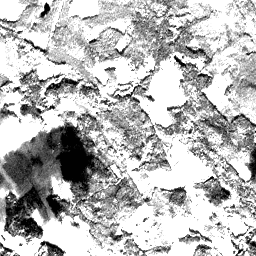

In [38]:
Image.fromarray(s2array[1]).show()